In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [16]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 1001)).cuda()
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi)))).cuda()

In [17]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable
gpytorch.functions.use_toeplitz = False

In [18]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=100, grid_bounds=[(0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)

model = GPClassificationModel().cuda()

In [19]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 1001)).cuda()
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.cpu().numpy(), pred_labels.data.cpu().numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

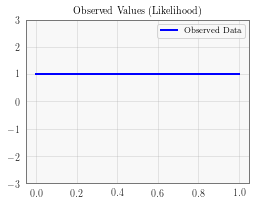

In [20]:
model.eval()
f = plot_model_and_predictions(model, plot_train_data=False)

In [21]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = model.forward(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.latent_function.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

Iter 1/200 - Loss: 477392.594   log_lengthscale: 0.000
Iter 2/200 - Loss: 407821.156   log_lengthscale: -0.100
Iter 3/200 - Loss: 292184.250   log_lengthscale: -0.178
Iter 4/200 - Loss: 235534.562   log_lengthscale: -0.258
Iter 5/200 - Loss: 215154.234   log_lengthscale: -0.345
Iter 6/200 - Loss: 138470.500   log_lengthscale: -0.431
Iter 7/200 - Loss: 146065.766   log_lengthscale: -0.512
Iter 8/200 - Loss: 84000.516   log_lengthscale: -0.591
Iter 9/200 - Loss: 83348.672   log_lengthscale: -0.667
Iter 10/200 - Loss: 72316.297   log_lengthscale: -0.739
Iter 11/200 - Loss: 42978.777   log_lengthscale: -0.817
Iter 12/200 - Loss: 40873.098   log_lengthscale: -0.894
Iter 13/200 - Loss: 19110.412   log_lengthscale: -0.978
Iter 14/200 - Loss: 33059.316   log_lengthscale: -1.065
Iter 15/200 - Loss: 13041.895   log_lengthscale: -1.143
Iter 16/200 - Loss: 30295.285   log_lengthscale: -1.226
Iter 17/200 - Loss: 29655.895   log_lengthscale: -1.305
Iter 18/200 - Loss: 33604.660   log_lengthscale: -1

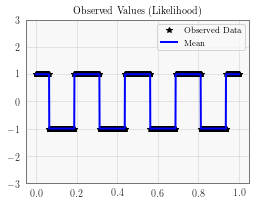

In [22]:
f = plot_model_and_predictions(model)